In [180]:
import qutip as qt
import pandas as pd
import numpy as np

import os
import glob



In [181]:

# list the folders in ../data
folders = glob.glob("../data/*")

folders = [f for f in folders if "1qb" in f]

# sort the folders by name
folders.sort()

folders


['../data/2025-05-19--14h-36m--2025-05-19--14h-37m_1qb_tomo_sagnac2_40mW_B_nominally_H',
 '../data/2025-05-19--14h-37m--2025-05-19--14h-37m_1qb_tomo_sagnac2_40mW_B_nominally_D',
 '../data/2025-05-19--14h-37m--2025-05-19--14h-38m_1qb_tomo_sagnac2_40mW_B_nominally_V',
 '../data/2025-05-19--14h-38m--2025-05-19--14h-39m_1qb_tomo_sagnac2_40mW_B_nominally_R',
 '../data/2025-05-19--14h-39m--2025-05-19--14h-39m_1qb_tomo_sagnac2_40mW_B_nominally_A',
 '../data/2025-05-19--14h-40m--2025-05-19--14h-40m_1qb_tomo_sagnac2_40mW_B_nominally_L',
 '../data/2025-05-19--14h-43m--2025-05-19--14h-43m_1qb_tomo_sagnac2_40mW_A_nominally_H',
 '../data/2025-05-19--14h-44m--2025-05-19--14h-44m_1qb_tomo_sagnac2_40mW_A_nominally_D',
 '../data/2025-05-19--14h-44m--2025-05-19--14h-45m_1qb_tomo_sagnac2_40mW_A_nominally_V',
 '../data/2025-05-19--14h-45m--2025-05-19--14h-45m_1qb_tomo_sagnac2_40mW_A_nominally_R',
 '../data/2025-05-19--14h-46m--2025-05-19--14h-46m_1qb_tomo_sagnac2_40mW_A_nominally_A',
 '../data/2025-05-19-

In [182]:
def extract_reconstructed_state(data, key="reconstructed_state"):

    matrix_11 = data[key][0][0]['real'] + 1j * data[key][0][0]['imag']
    matrix_12 = data[key][0][1]['real'] + 1j * data[key][0][1]['imag']
    matrix_21 = data[key][1][0]['real'] + 1j * data[key][1][0]['imag']
    matrix_22 = data[key][1][1]['real'] + 1j * data[key][1][1]['imag']

    matrix = [[matrix_11, matrix_12],
                [matrix_21, matrix_22]]
    return qt.Qobj(matrix, dims=[[2], [2]])



In [183]:
# for each folder, load the data in .../R/tomography_resutls.json and .../T/tomography_results.json

reconstructed_states = []

for folder in folders:
    last_part_of_folder = folder.split("/")[-1]

    # folder names like 2025-05-13--16h-29m--2025-05-13--16h-30m_1qb_tomo_sagnac2_40mW_B_nominally_H
    # extract the parameters from the folder name

    params = last_part_of_folder.split("_")
    nominal_state_name = params[-1]
    launcher = params[-3]
    laser_power = params[-4]

    R_file = os.path.join(folder, "R", "tomography_results.json")
    T_file = os.path.join(folder, "T", "tomography_results.json")

    if not os.path.exists(R_file) or not os.path.exists(T_file):
        print(f"Skipping {folder} because one of the files does not exist")
        continue

    R_data = pd.read_json(R_file)
    T_data = pd.read_json(T_file)

    rho_R = extract_reconstructed_state(R_data)
    rho_T = extract_reconstructed_state(T_data)
    
    target_state = extract_reconstructed_state(T_data, key="target_state")

    reconstructed_states.append({
        "folder": folder,
        "nominal_state_name": nominal_state_name,
        "launcher": launcher,
        "laser_power": laser_power,
        "reconstructed_state_T": rho_T,
        "reconstructed_state_R": rho_R,
        "target_state": target_state
    })

reconstructed_states[-1]['reconstructed_state_T']



Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.54113893+0.j         -0.21712898+0.43506817j]
 [-0.21712898-0.43506817j  0.45886107+0.j        ]]

In [184]:
def density_to_bloch_coords(rho):
    x = np.real((rho * qt.Qobj([[0, 1], [1, 0]])).tr())  # ⟨σx⟩
    y = np.real((rho * qt.Qobj([[0, -1j], [1j, 0]])).tr())  # ⟨σy⟩
    z = np.real((rho * qt.Qobj([[1, 0], [0, -1]])).tr())  # ⟨σz⟩
    return [x, y, z]


bloch = density_to_bloch_coords(reconstructed_states[0]['reconstructed_state_T'])
bloch

[0.0206922642766, -0.016488786881216, 0.9846075333137511]

In [185]:
# add the bloch coordinates to the reconstructed states
for state in reconstructed_states:
    bloch_coords_T = density_to_bloch_coords(state['reconstructed_state_T'])
    state['bloch_coords_T'] = bloch_coords_T
    bloch_coords_R = density_to_bloch_coords(state['reconstructed_state_R'])
    state['bloch_coords_R'] = bloch_coords_R

reconstructed_states[0]['bloch_coords_T']

[0.0206922642766, -0.016488786881216, 0.9846075333137511]

In [186]:
# b = qt.Bloch()
# bloch_coords_T = state['bloch_coords_T']
# b.add_points(bloch_coords_T)

# b.add_annotation(bloch_coords_T, state['launcher'] + "T")

# bloch_coords_R = state['bloch_coords_R']
# b.add_points(bloch_coords_R)

# b.add_annotation(bloch_coords_R, state['launcher'] + "R")

# Add points
for state in reconstructed_states:
    # new bloch sphere for each state
    b = qt.Bloch()
    b.view = [180, 90]
    # make the image bigger
    b.make_sphere()
    bloch_coords_T = state['bloch_coords_T']
    b.add_points(bloch_coords_T)
    print(state["nominal_state_name"])
    b.add_annotation(bloch_coords_T, "launcher: " + state['launcher'] + ", tomo: T, nominal state:" + state['nominal_state_name'], fontsize=8)
    bloch_coords_R = state['bloch_coords_R']
    b.add_points(bloch_coords_R)
    b.add_annotation(bloch_coords_R, "launcher: " + state['launcher'] + ", tomo: R, nominal state:" + state['nominal_state_name'], fontsize=8)

    # Display
    # b.show()

H
D
V
R
A
L
H
D
V
R
A
L


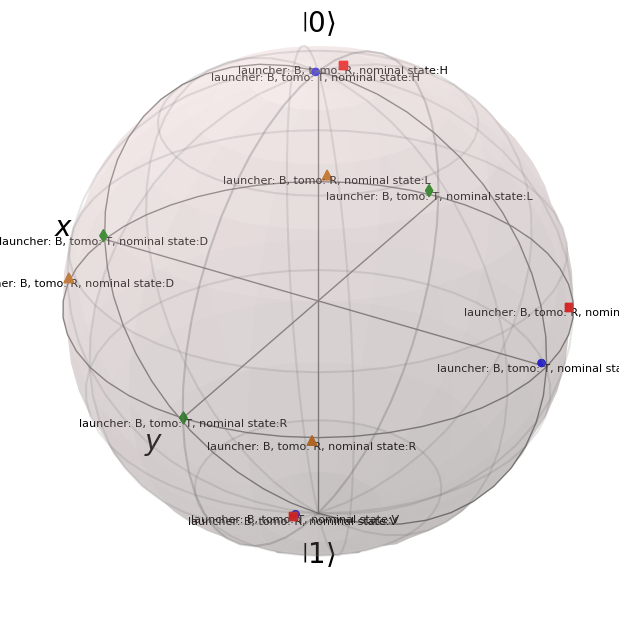

In [187]:
b = qt.Bloch()
b.view = [30, 30]
b.make_sphere()

for state in reconstructed_states[-12:-6]:
    bloch_coords_T = state['bloch_coords_T']
    b.add_points(bloch_coords_T)
    b.add_annotation(bloch_coords_T, "launcher: " + state['launcher'] + ", tomo: T, nominal state:" + state['nominal_state_name'], fontsize=8, verticalalignment='top')
    bloch_coords_R = state['bloch_coords_R']
    b.add_points(bloch_coords_R)
    b.add_annotation(bloch_coords_R, "launcher: " + state['launcher'] + ", tomo: R, nominal state:" + state['nominal_state_name'], fontsize=8, verticalalignment='top')

    # Display, ensuring the annotations are not cut off
b.fig.set_size_inches(6, 6)

b.show()


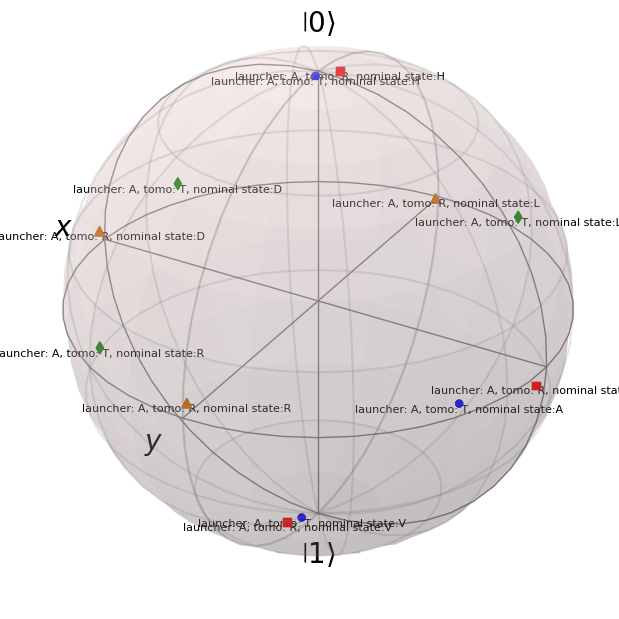

In [188]:
b = qt.Bloch()
b.view = [30, 30]
b.make_sphere()

for state in reconstructed_states[-6:]:
    bloch_coords_T = state['bloch_coords_T']
    b.add_points(bloch_coords_T)
    b.add_annotation(bloch_coords_T, "launcher: " + state['launcher'] + ", tomo: T, nominal state:" + state['nominal_state_name'], fontsize=8, verticalalignment='top')
    bloch_coords_R = state['bloch_coords_R']
    b.add_points(bloch_coords_R)
    b.add_annotation(bloch_coords_R, "launcher: " + state['launcher'] + ", tomo: R, nominal state:" + state['nominal_state_name'], fontsize=8, verticalalignment='top')

    # Display, ensuring the annotations are not cut off
b.fig.set_size_inches(6, 6)

b.show()


In [189]:
# for each of the launcher B states, find the phase angle of the state in the T tomography
def phase_angle(state):
    if state['launcher'] == "B":
        bloch_coords = state['bloch_coords_T']
    elif state['launcher'] == "A":
        bloch_coords = state['bloch_coords_R']
    else:
        raise ValueError("Launcher must be either A or B")
    # get the x and y coordinates
    x = bloch_coords[0]
    y = bloch_coords[1]
    # calculate the angle
    angle = np.arctan2(y, x)
    
    return angle

# get the phase angle for each state
phase_angles = []
for state in reconstructed_states:
    angle = phase_angle(state)
    phase_angles.append({
        "folder": state['folder'],
        "nominal_state_name": state['nominal_state_name'],
        "launcher": state['launcher'],
        "laser_power": state['laser_power'],
        "phase_angle": angle,
        "bloch_coords_T_x": state['bloch_coords_T'][0] *180 / np.pi,
        "bloch_coords_T_y": state['bloch_coords_T'][1]*180 / np.pi,
        "bloch_coords_R_x": state['bloch_coords_R'][0]*180 / np.pi,
        "bloch_coords_R_y": state['bloch_coords_R'][1]*180 / np.pi,
    })

# convert to dataframe
phase_angles_df = pd.DataFrame(phase_angles)

# add the phase angle in degrees
phase_angles_df['phase_angle_degrees'] = (phase_angles_df['phase_angle'] * 180 / np.pi) % 360

# add the intended phase angle based on the nominal state name
def intended_phase_angle(nominal_state_name):
    if nominal_state_name == "D":
        return 0
    elif nominal_state_name == "R":
        return 90
    elif nominal_state_name == "A":
        return 180
    elif nominal_state_name == "L":
        return 270

phase_angles_df['intended_phase_angle'] = phase_angles_df['nominal_state_name'].apply(intended_phase_angle)

# add the phase angle difference
phase_angles_df['phase_angle_difference'] = (phase_angles_df['phase_angle_degrees'] - phase_angles_df['intended_phase_angle']) % 360


phase_angles_df

,folder,nominal_state_name,launcher,laser_power,phase_angle,bloch_coords_T_x,bloch_coords_T_y,bloch_coords_R_x,bloch_coords_R_y,phase_angle_degrees,intended_phase_angle,phase_angle_difference
0,../data/2025-05-19--14h-36m--2025-05-19--14h-3...,H,B,40mW,-0.672822,1.185579,-0.944738,-2.536097,-6.259041,321.450146,NaN,NaN
1,../data/2025-05-19--14h-37m--2025-05-19--14h-3...,D,B,40mW,0.031992,56.365371,1.803846,50.018258,25.475197,1.832996,0.0,1.832996
2,../data/2025-05-19--14h-37m--2025-05-19--14h-3...,V,B,40mW,0.792015,3.834196,3.885272,3.890722,5.150182,45.379095,NaN,NaN
3,../data/2025-05-19--14h-38m--2025-05-19--14h-3...,R,B,40mW,1.564481,0.356528,56.451154,-27.179385,49.622214,89.638143,90.0,359.638143
4,../data/2025-05-19--14h-39m--2025-05-19--14h-3...,A,B,40mW,3.119593,-56.635623,1.246138,-49.909983,-25.803660,178.739540,180.0,358.739540
5,../data/2025-05-19--14h-40m--2025-05-19--14h-4...,L,B,40mW,-1.533048,2.134827,-56.527505,26.376326,-50.016177,272.162814,270.0,2.162814
6,../data/2025-05-19--14h-43m--2025-05-19--14h-4...,H,A,40mW,-2.272298,0.227696,0.684129,-3.194932,-3.781617,229.806917,NaN,NaN
7,../data/2025-05-19--14h-44m--2025-05-19--14h-4...,D,A,40mW,0.051906,51.279529,-22.620831,56.626126,2.941902,2.974019,0.0,2.974019
8,../data/2025-05-19--14h-44m--2025-05-19--14h-4...,V,A,40mW,1.114787,1.872896,4.399107,3.807899,7.763493,63.872612,NaN,NaN
9,../data/2025-05-19--14h-45m--2025-05-19--14h-4...,R,A,40mW,1.579587,24.860139,50.943164,-0.495329,56.343534,90.503687,90.0,0.503687


In [192]:
# Now for the reflected paths:
def phase_angle(state):
    if state['launcher'] == "B":
        bloch_coords = state['bloch_coords_R']
    elif state['launcher'] == "A":
        bloch_coords = state['bloch_coords_T']
    else:
        raise ValueError("Launcher must be either A or B")
    # get the x and y coordinates
    x = bloch_coords[0]
    y = bloch_coords[1]
    # calculate the angle
    angle = np.arctan2(y, x)
    
    return angle

# get the phase angle for each state
phase_angles = []
for state in reconstructed_states:
    angle = phase_angle(state)
    phase_angles.append({
        "folder": state['folder'],
        "nominal_state_name": state['nominal_state_name'],
        "launcher": state['launcher'],
        "laser_power": state['laser_power'],
        "phase_angle": angle,
        "bloch_coords_T_x": state['bloch_coords_T'][0] *180 / np.pi,
        "bloch_coords_T_y": state['bloch_coords_T'][1]*180 / np.pi,
        "bloch_coords_R_x": state['bloch_coords_R'][0]*180 / np.pi,
        "bloch_coords_R_y": state['bloch_coords_R'][1]*180 / np.pi,
    })

# convert to dataframe
phase_angles_df = pd.DataFrame(phase_angles)

# add the phase angle in degrees
phase_angles_df['phase_angle_degrees'] = (phase_angles_df['phase_angle'] * 180 / np.pi) % 360

# add the intended phase angle based on the nominal state name
def intended_phase_angle(nominal_state_name):
    if nominal_state_name == "D":
        return 0
    elif nominal_state_name == "R":
        return 90
    elif nominal_state_name == "A":
        return 180
    elif nominal_state_name == "L":
        return 270

phase_angles_df['intended_phase_angle'] = phase_angles_df['nominal_state_name'].apply(intended_phase_angle)

# add the phase angle difference
phase_angles_df['phase_angle_difference'] = (phase_angles_df['phase_angle_degrees'] - phase_angles_df['intended_phase_angle']) % 360


phase_angles_df.to_csv("phase_angles.csv", index=False)